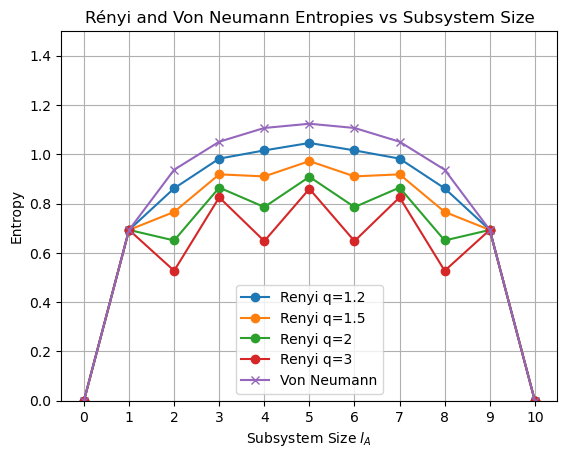

In [1]:
#Q1

import numpy as np
import matplotlib.pyplot as plt
import copy

# Set parameters
N = 10  # Number of sites in the spin chain
dimension = 2**N  # Total Hilbert space dimension
q_values = [1.2, 1.5, 2, 3]  # Rényi entropy parameters
method = 1  # Method for spin flipping (0 or 1)

# Reference state for padding (all spins down)
z = '0' * N

# Dictionary to store eigenvalues for each Mz sector
energy = {}

# Variables to track the global ground state
global_ground_energy = np.inf
global_ground_sector = None
global_ground_eigenvector = None

for num_up in range(0, N + 1):  # Iterate over possible number of spin-ups
    state_list = []
    for state in range(dimension):
        chain_here = bin(state)[2:].zfill(N)  # Convert state to binary string with leading zeros
        num_spinup = chain_here.count('1')  # Count number of '1's (spin-ups)
        if num_spinup == num_up:
            state_list.append(state)  # Add state to list if it matches num_up
    
    # Number of states in the current Mz sector
    num_states = len(state_list)
    
    if num_states == 0:
        continue  # Skip if no states in this sector
    
    # Initialize the block Hamiltonian for the current Mz sector
    Hmz = np.zeros((num_states, num_states))
    
    for a in range(num_states):
        for i in range(N):
            j = (i + 1) % N  # Periodic Boundary Condition
            s_a = bin(state_list[a])[2:].zfill(N)  # Binary string with leading zeros
            
            if s_a[i] == s_a[j]:
                Hmz[a, a] += 0.25  # Diagonal element for aligned spins
            else:
                Hmz[a, a] -= 0.25  # Diagonal element for anti-aligned spins
                
                # Flip spins at positions i and j
                chain_new = copy.deepcopy(s_a)
                element_i = chain_new[i]
                element_j = chain_new[j]
                
                if method == 0:
                    # Method 0: Concatenation way to exchange spins
                    if j == 0:
                        chain_new = element_i + chain_new[1:N-1] + element_j
                    else:
                        chain_new = chain_new[0:i] + element_j + element_i + chain_new[j+1:]
                    r = int(chain_new, 2)
                else:
                    # Method 1: Using list manipulation to exchange spins
                    chain1 = list(chain_new)
                    chain1[i] = element_j
                    chain1[j] = element_i
                    r = int(''.join(chain1), 2)
                
                try:
                    b = state_list.index(r)  # Find the index of the flipped state
                    Hmz[a, b] = 0.5  # Off-diagonal element representing spin flip interaction
                except ValueError:
                    # This should not happen as flipping spins within the sector preserves Mz
                    pass
    
    # Diagonalize the block Hamiltonian
    eig_vals = np.linalg.eigvalsh(Hmz)  # Since Hmz is Hermitian
    eig_vecs = np.linalg.eigh(Hmz)[1]  # Eigenvectors
    
    # Store eigenvalues
    energy[num_up] = eig_vals
    
    # Check if the current sector has the lowest energy so far
    current_ground_energy = eig_vals[0]  # Assuming eig_vals are sorted in ascending order
    if current_ground_energy < global_ground_energy:
        global_ground_energy = current_ground_energy
        global_ground_sector = num_up
        global_ground_eigenvector = eig_vecs[:, 0]  # Ground state eigenvector for this sector

# Reconstruct the global ground state wave function
gs = np.zeros(dimension, dtype=complex)

if global_ground_sector is not None:
    # Get the list of states in the ground sector
    ground_state_list = []
    for state in range(dimension):
        chain_here = bin(state)[2:].zfill(N)
        num_spinup = chain_here.count('1')
        if num_spinup == global_ground_sector:
            ground_state_list.append(state)
    
    # Map the sector's ground state eigenvector to the full Hilbert space
    for idx, state in enumerate(ground_state_list):
        gs[state] = global_ground_eigenvector[idx]

# Normalize the global ground state
gs /= np.linalg.norm(gs)

# Functions to compute Rényi and Von Neumann entropies
def cal_renyi(psi, lA, N, q):
    if lA == 0 or lA == N:
        return 0
    size1 = 2**lA
    size2 = 2**(N - lA)
    psi_reshaped = psi.reshape((size1, size2))
    rho_A = np.dot(psi_reshaped, psi_reshaped.conj().T)
    eigenvals = np.linalg.eigvalsh(rho_A)
    eigenvals = eigenvals[eigenvals > 0]
    renyi = (1 / (1 - q)) * np.log(np.sum(eigenvals**q))
    return renyi

def cal_von_neumann(psi, lA, N):
    if lA == 0 or lA == N:
        return 0
    size1 = 2**lA
    size2 = 2**(N - lA)
    psi_reshaped = psi.reshape((size1, size2))
    rho_A = np.dot(psi_reshaped, psi_reshaped.conj().T)
    eigenvals = np.linalg.eigvalsh(rho_A)
    eigenvals = eigenvals[eigenvals > 0]
    von_neumann = -np.sum(eigenvals * np.log(eigenvals))
    return von_neumann

# Subsystem sizes from 0 to N
lA_list = range(0, N + 1)

# Initialize dictionaries to store entropies
renyi_entropies = {q: [] for q in q_values}
von_neumann_entropies = []

# Compute entropies
for lA in lA_list:
    for q in q_values:
        S_q = cal_renyi(gs, lA, N, q)
        renyi_entropies[q].append(S_q)
    S_vn = cal_von_neumann(gs, lA, N)
    von_neumann_entropies.append(S_vn)

# Plot Rényi entropies
for q in q_values:
    plt.plot(lA_list, renyi_entropies[q], marker='o', label=f'Renyi q={q}')

# Plot Von Neumann entropy
plt.plot(lA_list, von_neumann_entropies, marker='x', label='Von Neumann')

# Configure plot
plt.xlabel('Subsystem Size $l_A$')
plt.ylabel('Entropy')
plt.title('Rényi and Von Neumann Entropies vs Subsystem Size')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.5)  # Set y-axis from 0 to 1.5
plt.xticks(range(0, N + 1))  # Set x-axis ticks from 0 to N
plt.show()

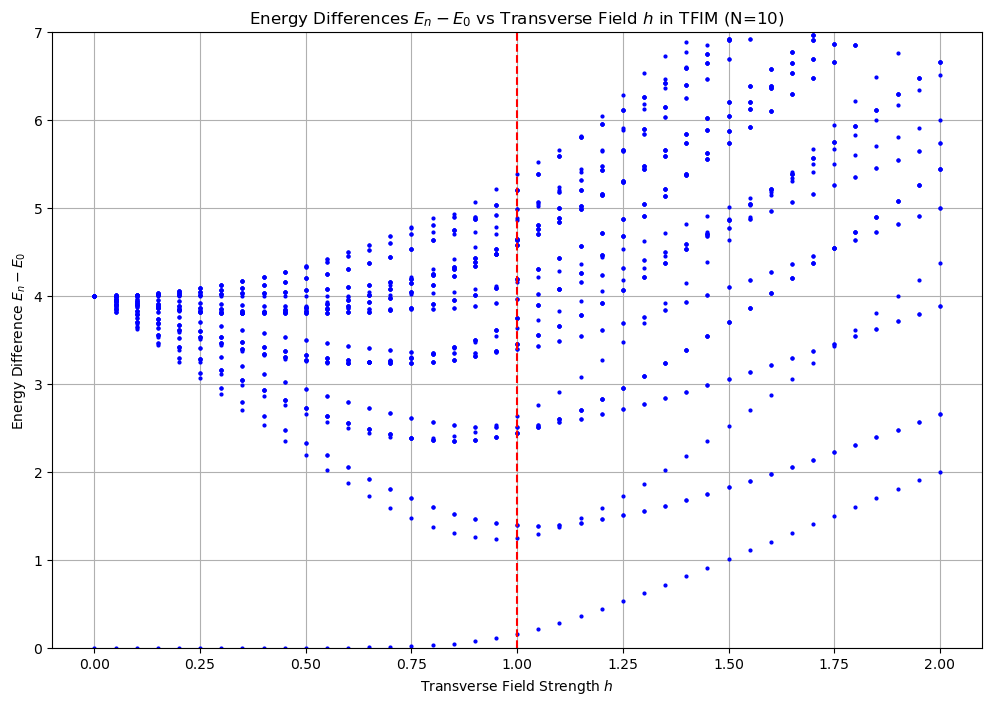

lA = 0, S2 = 0.0000
lA = 1, S2 = 0.3505
lA = 2, S2 = 0.4399
lA = 3, S2 = 0.4833
lA = 4, S2 = 0.5049
lA = 5, S2 = 0.5116
lA = 6, S2 = 0.5049
lA = 7, S2 = 0.4833
lA = 8, S2 = 0.4399
lA = 9, S2 = 0.3505
lA = 10, S2 = 0.0000


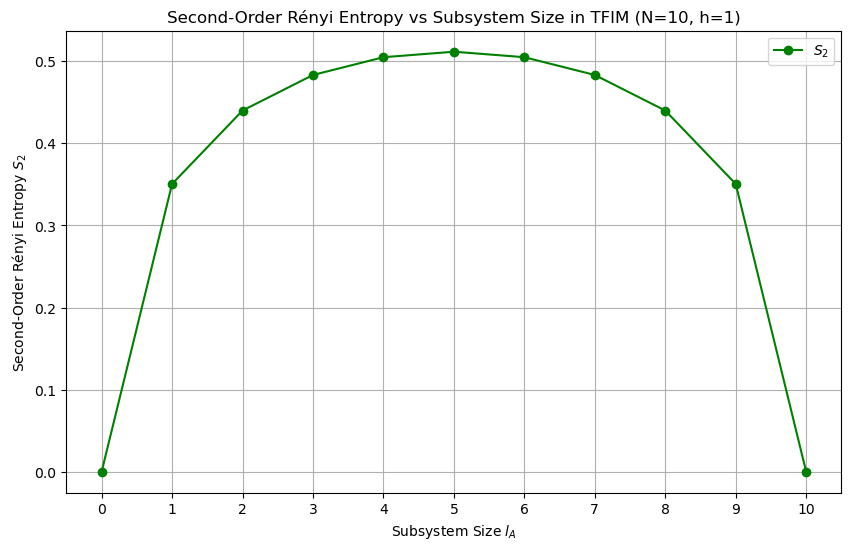


First 51 Eigenvalues at h=0:
E_0 = -10.00
E_1 = -10.00
E_2 = -6.00
E_3 = -6.00
E_4 = -6.00
E_5 = -6.00
E_6 = -6.00
E_7 = -6.00
E_8 = -6.00
E_9 = -6.00
E_10 = -6.00
E_11 = -6.00
E_12 = -6.00
E_13 = -6.00
E_14 = -6.00
E_15 = -6.00
E_16 = -6.00
E_17 = -6.00
E_18 = -6.00
E_19 = -6.00
E_20 = -6.00
E_21 = -6.00
E_22 = -6.00
E_23 = -6.00
E_24 = -6.00
E_25 = -6.00
E_26 = -6.00
E_27 = -6.00
E_28 = -6.00
E_29 = -6.00
E_30 = -6.00
E_31 = -6.00
E_32 = -6.00
E_33 = -6.00
E_34 = -6.00
E_35 = -6.00
E_36 = -6.00
E_37 = -6.00
E_38 = -6.00
E_39 = -6.00
E_40 = -6.00
E_41 = -6.00
E_42 = -6.00
E_43 = -6.00
E_44 = -6.00
E_45 = -6.00
E_46 = -6.00
E_47 = -6.00
E_48 = -6.00
E_49 = -6.00
E_50 = -6.00
E_1 - E_0 = 0.00
E_2 - E_0 = 4.00
E_3 - E_0 = 4.00
E_4 - E_0 = 4.00
E_5 - E_0 = 4.00
E_6 - E_0 = 4.00
E_7 - E_0 = 4.00
E_8 - E_0 = 4.00
E_9 - E_0 = 4.00
E_10 - E_0 = 4.00
E_11 - E_0 = 4.00
E_12 - E_0 = 4.00
E_13 - E_0 = 4.00
E_14 - E_0 = 4.00
E_15 - E_0 = 4.00
E_16 - E_0 = 4.00
E_17 - E_0 = 4.00
E_18 - E_0 = 4.00


In [2]:
#Q2

# Merged Python Script for Transverse Field Ising Model (TFIM) Analysis

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigsh
from itertools import combinations

def get_spin(state, site, N):
    """
    Get the spin at a specific site.
    Returns +1 for spin up ('1') and -1 for spin down ('0').
    """
    return 1 if (state >> site) & 1 else -1

def flip_spin(state, site):
    """
    Flip the spin at a specific site.
    """
    return state ^ (1 << site)

def construct_sparse_hamiltonian(N, h, J=1):
    """
    Construct the Hamiltonian matrix for the Transverse Field Ising Model using sparse representation.
    
    Parameters:
    - N: Number of spins
    - h: Transverse field strength
    - J: Interaction strength (default is 1)
    
    Returns:
    - H: Hamiltonian matrix as a SciPy CSR sparse matrix of shape (2^N, 2^N)
    """
    dim = 2**N
    H = lil_matrix((dim, dim), dtype=np.float64)
    
    for state in range(dim):
        # Diagonal terms: Interaction between neighboring spins
        interaction = 0
        for i in range(N):
            j = (i + 1) % N  # Periodic Boundary Conditions
            spin_i = get_spin(state, i, N)
            spin_j = get_spin(state, j, N)
            interaction += spin_i * spin_j
        H[state, state] += -J * interaction
        
        # Off-diagonal terms: Transverse field causing spin flips
        for i in range(N):
            flipped_state = flip_spin(state, i)
            H[state, flipped_state] += -h
    return H.tocsr()

def diagonalize_sparse_hamiltonian(N, h_values, J=1, target_states=range(1,51), num_eigenvalues=51):
    """
    Diagonalize the Hamiltonian for each value of h and extract the desired energy levels using sparse matrices.
    
    Parameters:
    - N: Number of spins
    - h_values: List or array of transverse field strengths
    - J: Interaction strength (default is 1)
    - target_states: Iterable of target state indices to extract (default is 1 to 50)
    - num_eigenvalues: Number of lowest eigenvalues to compute (default is 51)
    
    Returns:
    - energies_diff: Dictionary where keys are target_state and values are lists of energy differences E_n - E_0 for each h
    - ground_states: List of ground state wavefunctions for each h
    """
    energies_diff = {n: [] for n in target_states}
    ground_states = []
    
    for h in h_values:
        H = construct_sparse_hamiltonian(N, h, J)
        
        try:
            # Compute the lowest num_eigenvalues eigenvalues and eigenvectors using eigsh
            eigenvals, eigenvecs = eigsh(H, k=num_eigenvalues, which='SA')
            
            # Sort eigenvalues and eigenvectors in ascending order
            idx = np.argsort(eigenvals)
            eigenvals_sorted = eigenvals[idx]
            eigenvecs_sorted = eigenvecs[:, idx]
            
            # Ground state energy and wavefunction
            E0 = eigenvals_sorted[0]
            psi_ground = eigenvecs_sorted[:, 0]
            ground_states.append(psi_ground)
            
            # Compute energy differences for all target_states
            for n in target_states:
                if n < len(eigenvals_sorted):
                    En = eigenvals_sorted[n]
                    energies_diff[n].append(En - E0)
                else:
                    print(f"Warning: Requested target_state={n} exceeds available eigenvalues for h={h}.")
                    energies_diff[n].append(np.nan)
        except Exception as e:
            print(f"An error occurred for h = {h:.2f}: {e}")
            for n in target_states:
                energies_diff[n].append(np.nan)
            ground_states.append(None)
    
    return energies_diff, ground_states

def compute_renyi_entropy(psi, lA, N):
    """
    Compute the second-order Rényi entropy for a given subsystem size.
    
    Parameters:
    - psi: Ground state wavefunction (array of size 2^N)
    - lA: Size of subsystem A
    - N: Total number of spins
    
    Returns:
    - S2: Second-order Rényi entropy
    """
    if lA == 0 or lA == N:
        return 0.0
    
    # Reshape psi into a matrix with dimensions (2^lA, 2^(N-lA))
    psi_matrix = psi.reshape((2**lA, 2**(N-lA)))
    
    # Compute the reduced density matrix rho_A by tracing out subsystem B
    rho_A = np.dot(psi_matrix, psi_matrix.conj().T)
    
    # Compute Tr[rho_A^2]
    tr_rho_A_sq = np.trace(np.dot(rho_A, rho_A)).real
    
    # Compute S2 = -log(Tr[rho_A^2])
    S2 = -np.log(tr_rho_A_sq)
    
    return S2

def print_eigenvalues_at_h_zero(N, J=1, target_states=range(1,51), num_eigenvalues=51):
    """
    Diagonalize the Hamiltonian at h=0 and print the first 51 eigenvalues for verification.
    
    Parameters:
    - N: Number of spins
    - J: Interaction strength (default is 1)
    - target_states: Iterable of target state indices to extract (default is 1 to 50)
    - num_eigenvalues: Number of lowest eigenvalues to compute (default is 51)
    """
    h = 0
    H = construct_sparse_hamiltonian(N, h, J)
    
    try:
        eigenvals, _ = eigsh(H, k=num_eigenvalues, which='SA')
        eigenvals_sorted = np.sort(eigenvals)
        
        print("\nFirst 51 Eigenvalues at h=0:")
        for idx, val in enumerate(eigenvals_sorted):
            print(f"E_{idx} = {val:.2f}")
        
        E0 = eigenvals_sorted[0]
        for n in target_states:
            if n < len(eigenvals_sorted):
                E_target = eigenvals_sorted[n]
                print(f"E_{n} - E_0 = {E_target - E0:.2f}")
            else:
                print(f"E_{n} - E_0: Not available (index out of range)")
    except Exception as e:
        print(f"An error occurred during eigenvalue computation at h=0: {e}")

def main():
    # Global Parameters
    N = 10  # Number of spins
    J = 1   # Interaction strength
    target_states = range(1, 51)  # Target states from 1 to 50
    num_eigenvalues = 51  # Number of eigenvalues to compute

    # -------------------------------------------------------------------------
    # Part 1: Compute and Plot Energy Differences E_n - E_0 vs Transverse Field h
    # -------------------------------------------------------------------------
    h_values = np.arange(0, 2.05, 0.05)  # Transverse field from 0 to 2 in steps of 0.05
    energies_diff, ground_states = diagonalize_sparse_hamiltonian(N, h_values, J, target_states, num_eigenvalues)

    # Convert energies_diff to a 2D array for easier plotting
    energies_diff_array = np.array([energies_diff[n] for n in target_states])

    # Plot Energy Differences vs h for multiple target_states
    plt.figure(figsize=(12, 8))
    for idx, n in enumerate(target_states):
        plt.plot(h_values, energies_diff_array[idx], marker='o', linestyle='None', color='blue', markersize=2)

    plt.xlabel('Transverse Field Strength $h$')
    plt.ylabel('Energy Difference $E_n - E_0$')
    plt.title('Energy Differences $E_n - E_0$ vs Transverse Field $h$ in TFIM (N=10)')
    plt.grid(True)
    plt.axvline(x=1, color='r', linestyle='--', label='$h_c = 1$')
    plt.ylim(0, 7)  # Set y-axis from 0 to 7
    plt.show()
    
    # -------------------------------------------------------------------------
    # Part 2: Compute and Plot Second-Order Rényi Entropy S2 vs Subsystem Size lA at h=1
    # -------------------------------------------------------------------------
    h_renyi = 1  # Transverse field at critical point
    
    # Find the index in h_values closest to h_renyi
    idx_h = np.argmin(np.abs(h_values - h_renyi))
    if ground_states[idx_h] is not None:
        psi_ground = ground_states[idx_h]
        psi_ground = psi_ground / np.linalg.norm(psi_ground)  # Normalize the ground state
        
        # Compute second-order Rényi entropy for each lA
        lA_values = range(0, N+1)  # Subsystem sizes from 0 to N
        renyi_entropies = []
        for lA in lA_values:
            S2 = compute_renyi_entropy(psi_ground, lA, N)
            renyi_entropies.append(S2)
            print(f"lA = {lA}, S2 = {S2:.4f}")
        
        # Plot Rényi Entropy vs Subsystem Size
        plt.figure(figsize=(10, 6))
        plt.plot(lA_values, renyi_entropies, marker='o', linestyle='-', color='g', label='$S_2$')
        plt.xlabel('Subsystem Size $l_A$')
        plt.ylabel('Second-Order Rényi Entropy $S_2$')
        plt.title(f'Second-Order Rényi Entropy vs Subsystem Size in TFIM (N={N}, h={h_renyi})')
        plt.grid(True)
        plt.legend()
        plt.xticks(lA_values)
        plt.show()
    else:
        print(f"Ground state at h = {h_renyi} is not available.")
    
    # -------------------------------------------------------------------------
    # Part 3: Verification by Printing Eigenvalues at h=0
    # -------------------------------------------------------------------------
    print_eigenvalues_at_h_zero(N, J, target_states, num_eigenvalues)

if __name__ == "__main__":
    main()



Q1 we got the same figure as figure 1. 

Q2(a) we can interpret quantum phase transition at h_c = 1 from these data, as we can we see from the result the trasition from disordered to ordered phase is at h_c = 1. For example, for energy level 2, there is a rapid increase in the energy level at h = 1. This is a sign of phase transition. This also applies to the other energy levels.

Q2(b) The figure is the same as figure 3. 

